In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Exploratory Data Analysis (Ross)
See Week 3 -> Lab 2

In [2]:
df = pd.read_json("./russian_ads.json")

In [3]:
df.head(5)

,language_categories,placement_categories,interests_categories,location_categories,ad_id,ad_copy,ad_landing_page,ad_targeting_location,age_lower,age_upper,...,interest_expansion,excluded_connections,language,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,interests_categories_regex,location_categories_regex,date_order_index
0,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",331.0,"""Free Figure's Black Power Rally at VCU:""",https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,...,None,None,None,1.66,460.24,25.90,0.06,,Midwest_Atlantic,41
1,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",332.0,A woman pretended Afro-American to gain contro...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,...,None,None,None,1.63,414.72,28.83,0.07,,Midwest_Atlantic,42
2,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",333.0,2Pac believed in FightTupac Shakur was indeed ...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,...,None,None,None,3.21,334.89,14.64,0.04,,Midwest_Atlantic,43
3,[Not Specified],[Facebook],[African American],"[Midwest, Atlantic]",334.0,Today we celebrate the legendary rapper who ev...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,...,People who like Black Matters. Friends of conn...,None,None,1.66,92.17,6.02,0.07,African American,Midwest_Atlantic,44
4,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",335.0,It is an American history. African-American ci...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,...,None,None,None,1.55,307.10,16.77,0.05,,Midwest_Atlantic,45


In [4]:
df.describe()

,ad_id,age_lower,age_upper,ad_impressions,ad_clicks,ad_spend_rub,day,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,date_order_index
count,3366.000000,3516.000000,3516.000000,3.514000e+03,3517.000000,2730.000000,3517.000000,2730.000000,2545.000000,2548.000000,2600.000000,3517.000000
mean,1708.480095,17.773606,829.393060,1.154021e+04,1061.688655,2152.026484,14.906739,33.955451,1450.455847,184.536016,0.102435,1758.000000
std,1005.571728,2.726394,364.857044,4.544945e+04,3376.498875,10178.730781,7.478779,170.349380,3559.251916,402.649345,0.078389,1015.414776
min,1.000000,13.000000,17.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.860000,0.000000,0.000000,0.000000
25%,842.250000,18.000000,999.000000,0.000000e+00,0.000000,100.000000,10.000000,1.602500,160.750000,7.160000,0.050000,879.000000
50%,1683.500000,18.000000,999.000000,1.034500e+03,70.000000,300.000000,14.000000,4.900000,408.700000,33.760000,0.100000,1758.000000
75%,2550.750000,18.000000,999.000000,8.428000e+03,827.000000,700.000000,21.000000,10.750000,1334.090000,196.697500,0.150000,2637.000000
max,3519.000000,45.000000,999.000000,1.334544e+06,73063.000000,331675.750000,31.000000,6100.210000,93832.950000,7726.070000,1.690000,3516.000000


In [5]:
df.apply(lambda x: sum(x.isnull()), axis=0)

language_categories              0
placement_categories             0
interests_categories             0
location_categories              0
ad_id                          151
ad_copy                         40
ad_landing_page                 29
ad_targeting_location           31
age_lower                        1
age_upper                        1
age                              1
placements                       0
ad_impressions                   3
ad_clicks                        0
ad_spend_rub                   787
ad_creation_date                 2
month                            0
year                             0
day                              0
ad_end_date                   1144
extra_data                       1
pdf_filepath                     0
image_filepath                   0
interest_expansion             292
excluded_connections          2559
language                      1909
ad_spend_usd                   787
efficiency_impressions         972
efficiency_clicks   

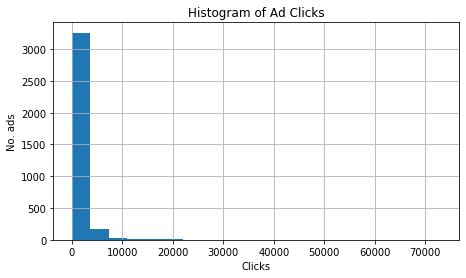

In [6]:
# Create figure with two subplots
fig = plt.figure(figsize=(16,4))

# Plot LoanAmount
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of Ad Clicks")
ax1.set_xlabel('Clicks')
ax1.set_ylabel('No. ads')
df['ad_clicks'].hist(bins=20)

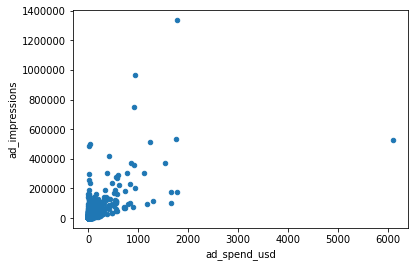

In [7]:
df.plot.scatter(x='ad_spend_usd', y='ad_impressions')

# 5. Clustering and Manifold Learning (Niall)
See Week 7 -> Lab 6

### Importing modules, data

In [8]:
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

pd.set_option('display.max_columns', None)

In [9]:
dfCluster = pd.read_json("./russian_ads.json")

### Converting lists into tuples, numbers

In [10]:
listCols = ['language_categories', 'placement_categories', 'interests_categories', 'location_categories']
dateCols = ['month', 'year']
numCols = ['age_lower', 'age_upper', 'ad_impressions', 'ad_clicks', 'ad_spend_usd', 'month', 'year']

for col in listCols:
    dfCluster[col] = dfCluster[col].transform(tuple)

for col in dateCols:
    dfCluster[col] = dfCluster[col].apply(''.join).astype(int)
    
for col in numCols:
    dfCluster[col] = pd.to_numeric(dfCluster[col], errors='coerce')
    
dfCluster.head(5)

,language_categories,placement_categories,interests_categories,location_categories,ad_id,ad_copy,ad_landing_page,ad_targeting_location,age_lower,age_upper,age,placements,ad_impressions,ad_clicks,ad_spend_rub,ad_creation_date,month,year,day,ad_end_date,extra_data,pdf_filepath,image_filepath,interest_expansion,excluded_connections,language,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,interests_categories_regex,location_categories_regex,date_order_index
0,"(Not Specified,)","(Facebook,)",(),"(Midwest, Atlantic)",331.0,"""Free Figure's Black Power Rally at VCU:""",https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,764.0,43,90.86,06/15/2015,6,2015,15,06/16/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002117.pdf,missing_ad.png,None,None,None,1.66,460.24,25.90,0.06,,Midwest_Atlantic,41
1,"(Not Specified,)","(Facebook,)",(),"(Midwest, Atlantic)",332.0,A woman pretended Afro-American to gain contro...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,676.0,47,89.51,06/15/2015,6,2015,15,06/16/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002118.pdf,missing_ad.png,None,None,None,1.63,414.72,28.83,0.07,,Midwest_Atlantic,42
2,"(Not Specified,)","(Facebook,)",(),"(Midwest, Atlantic)",333.0,2Pac believed in FightTupac Shakur was indeed ...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,1075.0,47,174.40,06/16/2015,6,2015,16,06/17/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002119.pdf,missing_ad.png,None,None,None,3.21,334.89,14.64,0.04,,Midwest_Atlantic,43
3,"(Not Specified,)","(Facebook,)","(African American,)","(Midwest, Atlantic)",334.0,Today we celebrate the legendary rapper who ev...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,153.0,10,90.07,06/16/2015,6,2015,16,06/17/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002120.pdf,missing_ad.png,People who like Black Matters. Friends of conn...,None,None,1.66,92.17,6.02,0.07,African American,Midwest_Atlantic,44
4,"(Not Specified,)","(Facebook,)",(),"(Midwest, Atlantic)",335.0,It is an American history. African-American ci...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,476.0,26,84.15,06/16/2015,6,2015,16,06/17/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002121.pdf,missing_ad.png,None,None,None,1.55,307.10,16.77,0.05,,Midwest_Atlantic,45


### Making a dataset out of numeric fields

In [11]:
dfClusterNum = dfCluster[['age_lower', 'age_upper', 'ad_impressions', 'ad_clicks', 'ad_spend_usd', 'month', 'year']]
dfClusterNum['ad_id'] = range(1, len(dfClusterNum) + 1)

# cluster_data = np.array(dfClusterNum.values, dtype=float)
# print('(number of examples, number of attributes): ', cluster_data.shape)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Encoding interesting categorical fields into numbers

In [12]:
dfEncoded= pd.get_dummies(dfCluster[['placement_categories', 'interests_categories', 'location_categories_regex']])
dfEncoded['ad_id'] = range(1, len(dfEncoded) + 1)

In [13]:
dfNumEncode = pd.merge(dfClusterNum, dfEncoded, on='ad_id', how='inner').dropna()
dfNumEncode.drop(['ad_id'], axis=1, inplace=True)
dfNumEncode

,age_lower,age_upper,ad_impressions,ad_clicks,ad_spend_usd,month,year,"placement_categories_('Facebook',)","placement_categories_('Facebook', 'Instagram')","placement_categories_('Facebook', 'Third Party Apps')","placement_categories_('Facebook', 'Video')","placement_categories_('Instagram',)",interests_categories_(),"interests_categories_('Above Age 30', 'Anti-Immigrant')","interests_categories_('Above Age 30', 'Conservative')","interests_categories_('Above Age 30', 'Patriotism')","interests_categories_('Above Age 30', 'Police')","interests_categories_('Above Age 30', 'Progressive')","interests_categories_('Above Age 30', 'Progressive', 'LGBTQ')","interests_categories_('African American',)","interests_categories_('African American', 'Below Age 30')","interests_categories_('African American', 'Conservative')","interests_categories_('African American', 'Geographic')","interests_categories_('African American', 'Gun Rights')","interests_categories_('African American', 'Islam')","interests_categories_('African American', 'Latinx')","interests_categories_('African American', 'Police')","interests_categories_('African American', 'Police', 'Progressive')","interests_categories_('African American', 'Products')","interests_categories_('African American', 'Products', 'Progressive')","interests_categories_('African American', 'Progressive')","interests_categories_('African American', 'Progressive', 'Conservative')","interests_categories_('African American', 'Texas', 'Christianity')","interests_categories_('American South',)","interests_categories_('American South', 'Conservative')","interests_categories_('American South', 'Gun Rights')","interests_categories_('American South', 'Gun Rights', 'Army')","interests_categories_('American South', 'Patriotism')","interests_categories_('Anti-Immigrant',)","interests_categories_('Army',)","interests_categories_('Army', 'Conservative')","interests_categories_('Army', 'Police', 'Gun Rights', 'Conservative')","interests_categories_('Christianity',)","interests_categories_('Christianity', 'Below Age 30')","interests_categories_('Christianity', 'Conservative')","interests_categories_('Conservative',)","interests_categories_('Conservative', 'Above Age 30', 'Army')","interests_categories_('Conservative', 'American South', 'Army')","interests_categories_('Conservative', 'Anti-Immigrant')","interests_categories_('Conservative', 'Christianity', 'Anti-Immigrant')","interests_categories_('Conservative', 'Gun Rights', 'Anti-Immigrant')","interests_categories_('Conservative', 'Patriotism', 'Army')","interests_categories_('Geographic',)","interests_categories_('Geographic', 'Progressive')","interests_categories_('Geographic', 'Texas')","interests_categories_('Geographic', 'Texas', 'Conservative')","interests_categories_('Gun Rights',)","interests_categories_('Gun Rights', 'Anti-Immigrant')","interests_categories_('Gun Rights', 'Conservative')","interests_categories_('Gun Rights', 'Texas')","interests_categories_('Islam',)","interests_categories_('LGBTQ',)","interests_categories_('LGBTQ', 'Progressive')","interests_categories_('LGBTQ', 'Progressive', 'Conservative')","interests_categories_('Latinx',)","interests_categories_('Memes', 'Memes and Products')","interests_categories_('Memes', 'Memes and Products', 'Below Age 30')","interests_categories_('Memes', 'Memes and Products', 'Conservative')","interests_categories_('Native American',)","interests_categories_('Patriotism',)","interests_categories_('Patriotism', 'Army')","interests_categories_('Patriotism', 'Army', 'Conservative', 'Police', 'American South', 'Gun Rights')","interests_categories_('Patriotism', 'Conservative')","interests_categories_('Police',)","interests_categories_('Police', 'Progressive')","interests_categories_('Police', 'Progressive', 'Unknown', 'Conservative', 'Anti-Immigrant', 'Patriotism')","interests_categories_('Prison',)","interests_categories_('Products',)","interests_categories_('Products', 'Below Age 30')","interests_categories_('Pro

### Combining these into a dataframe and array

In [14]:
numEncode_data = np.array(dfNumEncode.values, dtype=float)
print('(number of examples, number of attributes): ', numEncode_data.shape)

(number of examples, number of attributes):  (2726, 156)


### Scaling the data

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()
numEncode_data = min_max_scaler.fit_transform(numEncode_data)

## Scatterplot function
From lab 6

In [16]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### K-means Clustering

In [17]:
k = 3
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(numEncode_data)

## Manifold Learning

In [18]:
# append the cluster centers to the dataset
numEncode_data_and_centers = np.r_[numEncode_data,clustered_data_sklearn.cluster_centers_]

###  Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space¶

In [ ]:
# project both th data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.MDS(n_components=2).fit_transform(numEncode_data_and_centers)
print("transformation complete")

In [ ]:
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

In [ ]:
# project both th data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(lab6_data_and_centers)
print("transformation complete")

In [ ]:
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

## Clutster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [ ]:
dfNumEncode['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=dfNumEncode.index)

In [ ]:
dfNumEncode.head()

In [ ]:
lab6_df.groupby('cluster').mean()